In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
import pandas as pd
import numpy as np

# 반환값이 컬럼객체다
from pyspark.sql.functions import when, udf, col, regexp_replace
from pyspark.sql.types import DoubleType,IntegerType, StringType

# 스파크 통계
import pyspark.sql.functions as F

In [158]:
# https://wikidocs.net/book/2350

In [2]:
sc = SparkContext( 'local' ) # spark://ip:7070 -> 분산 클러스터 이용가능 
sqlCtx = SQLContext( sc )

In [3]:
df = sqlCtx.read.csv( path   = '../data/data1/titanic1.csv',
                      header = True,
                      inferSchema = True # shcema 자동 추정,
                    )

In [6]:
df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = true)
 |-- Sex_index: double (nullable = true)
 |-- Embarked_index: double (nullable = true)
 |-- Initial_index: double (nullable = true)



- Survived: integer (nullable = true) 생존 여부
- Pclass: integer (nullable = true) 등급
- Age: double (nullable = true) 나이
- SibSp: integer (nullable = true) 같이 탄 사람의 인원
- Parch: integer (nullable = true) 직계가족
- Fare: double (nullable = true) 금액
- Family_Size: integer (nullable = true) 가족 규모
- Alone: integer (nullable = true) 1인 경우 혼자, 0이면 혼자가 아님
- Sex_index: double (nullable = true) 성별 (0=여성, 1=남성)
- Embarked_index: double (nullable = true) 탑승 항구
- Initial_index: double (nullable = true) 

# spark 데이터프레임 멤버함수를 이용하여 아래를 구하시요.
1. age 컬럼 null 의 갯수를 구하시요
2. age null 평균값을 채우시요..
3. 등급별(pclass) 평균 생존을 구하시요
4. 혼자탑승(alone)한 인원의 평균 생존을 구하시요
5. 나이분류 컬럼을 추가하시요 
6. 연령대 컬럼을 추가하시요: 1~15(미성년자), 15~25(청년), 25~35(중년), 
35~60(장년), 60~(노년)  
7. 나이분류를 파이차트로 표시하시요

In [95]:
# 1번
# filter
df.filter("Age is null").count()

0

In [92]:
# where
df.where("Age is null").show()

+--------+------+---+-----+-----+----+-----------+-----+---------+--------------+-------------+
|Survived|Pclass|Age|SibSp|Parch|Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+---+-----+-----+----+-----------+-----+---------+--------------+-------------+
+--------+------+---+-----+-----+----+-----------+-----+---------+--------------+-------------+



In [71]:
# 2번 
df.fillna({'Age': df.agg( F.mean( df['Age']) ).collect()[0][0] } ).show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|
|       0|     3|33.0|    0|    0| 8.4583|          0|    1|      0.0|           2.0|          0.0|
|       0|     1|54.0|    0|    0|51.8625|          0|    1|      0.0|           0.0|          0.0|


# groupby

In [136]:
# 3. 등급별(pclass) 평균 생존을 구하시요
# (1)
df.groupBy( 'pclass' ).agg( F.mean('Survived').alias('등급별 생존율') ).show()

+------+-------------------+
|pclass|      등급별 생존율|
+------+-------------------+
|     1| 0.6296296296296297|
|     3|0.24236252545824846|
|     2|0.47282608695652173|
+------+-------------------+



In [145]:
# (2)
df.groupBy( 'pclass' ).mean('Survived').show()

+------+-------------------+
|pclass|      avg(Survived)|
+------+-------------------+
|     1| 0.6296296296296297|
|     3|0.24236252545824846|
|     2|0.47282608695652173|
+------+-------------------+



In [133]:
# 4. 혼자탑승(alone)한 인원의 평균 생존을 구하시요
# (1)
df.groupBy( 'Alone' ).mean('Survived').where('Alone == 1').show()

+-----+-------------------+
|Alone|      avg(Survived)|
+-----+-------------------+
|    1|0.30353817504655495|
+-----+-------------------+



In [150]:
# (2)
df.groupBy( 'Alone' ).agg( F.mean('Survived') ).where('Alone == 1').show()

+-----+-------------------+
|Alone|      avg(Survived)|
+-----+-------------------+
|    1|0.30353817504655495|
+-----+-------------------+



In [155]:
# 5. 나이분류 컬럼 추가
p_df = df.withColumn( '나이분류', when( df['Age'] <= 15, '미성년자' ).\
                           when(  df['Age'] <= 25, '청년').\
                           when(  df['Age'] <= 35, '중년').\
                           when(  df['Age'] <= 60, '장년').\
                           otherwise( '노년' ) ).toPandas()[['Age','나이분류']]
p_df

,Age,나이분류
0,22.0,청년
1,38.0,장년
2,26.0,중년
3,35.0,중년
4,35.0,중년
...,...,...
886,27.0,중년
887,19.0,청년
888,22.0,청년
889,26.0,중년


In [156]:
p_df.groupby('나이분류').count()

,Age
나이분류,
노년,22
미성년자,87
장년,212
중년,316
청년,254


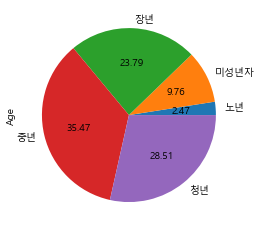

In [157]:
# 7. 나이분류를 파이차트로 표시하시요
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

p_df.groupby('나이분류').count()['Age'].plot( kind='pie', autopct = '%2.2f')

plt.show()